## Load Cleaned Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import stats as st

warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import Image

In [5]:
# initialize the datasets... UPDATE THIS
test = pd.read_csv("/Users/sashacrowe/Downloads/test.csv")
control = pd.read_csv("/Users/sashacrowe/Downloads/control.csv")
demo = pd.read_csv("/Users/sashacrowe/Downloads/demo.csv")
exp = pd.read_csv("/Users/sashacrowe/Downloads/exp.csv")

## Design Effectiveness 
1. Were the clients randomly & equally divided b/w the test (new) & control (old) designs?
2. Are there any biases?
3. Was the experiment well-structured?

**Duration Assessment**
- Was the timeframe of the experiment (from 3/15/2017 to 6/20/2017) adequate to gather meaningful data and insights? 


In [7]:
demo_exp = pd.merge(demo, exp, on="client_id")

In [8]:
demo_exp.client_id.nunique()

70609

In [9]:
demo_exp.shape

(70609, 10)

### Age bias check b/w test & control ... & population

In [ ]:
sns.histplot(demo['clnt_age'], kde=True, bins=30, color='red').set_title("Client's Age Distribution")

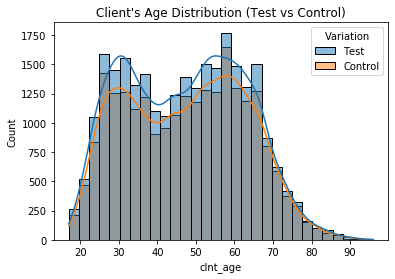

In [486]:
sns.histplot(data=demo_exp, x="clnt_age", hue="Variation", kde=True, bins=30, color='red').set_title("Client's Age Distribution (Test vs Control)");

Age distribution between Control & Test Group are relatively the same with the whole clients data in demo.

In [6]:
# the two below histograms are the indiv. histograms that are making up the above graph

Text(0.5, 1.0, "Client's Age Distribution (Control Group)")

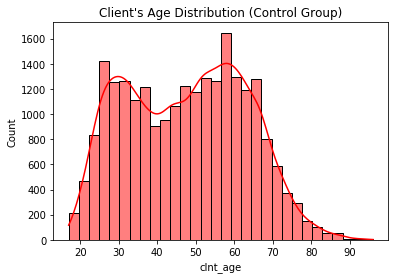

In [485]:
sns.histplot(demo_exp['clnt_age'][demo_exp["Variation"]=="Control"], kde=True, bins=30, color='red').set_title("Client's Age Distribution (Control Group)")

Text(0.5, 1.0, "Client's Age Distribution (Test Group)")

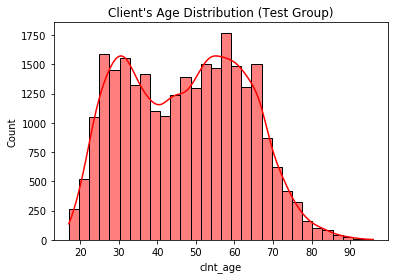

In [484]:
sns.histplot(demo_exp['clnt_age'][demo_exp["Variation"]=="Test"], kde=True, bins=30, color='red').set_title("Client's Age Distribution (Test Group)")

### Bias check for other variables b/w test & control ... & population

<Axes: xlabel='clnt_tenure_yr', ylabel='Count'>

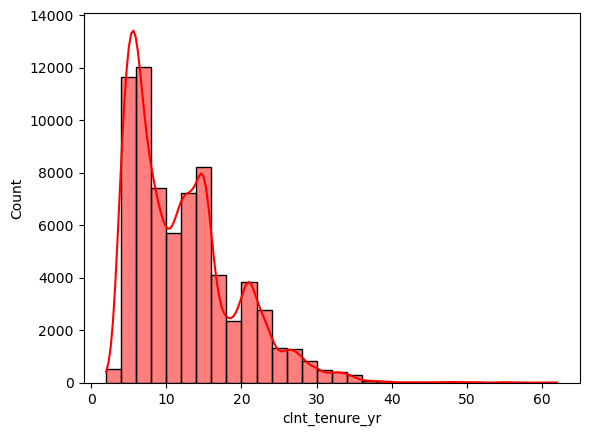

In [225]:
sns.histplot(demo['clnt_tenure_yr'], kde=True, bins=30, color='red')

In [226]:
pd.crosstab(demo["calls_6_mnth"], demo["logons_6_mnth"])

logons_6_mnth,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
calls_6_mnth,,,,,,,,,
0.0,0,0,7311,347,53,10,6,4,1
1.0,2938,134,27,7514,340,49,10,2,2
2.0,0,2875,149,10,6894,279,34,9,2
3.0,0,0,2756,128,10,5633,199,24,2
4.0,0,0,0,2221,100,4,4668,164,18
5.0,0,0,0,0,1857,60,3,4607,100
6.0,0,0,0,0,0,1843,44,0,12225
7.0,0,0,0,0,0,0,4929,0,0


In [481]:
demo['log_bal'] = np.log1p(demo['bal'])

## Performance Metrics

1. Completion Rate: The proportion of users who reach the final ‘confirm’ step.
2. Time Spent on Each Step: The average duration users spend on each step.
3. Error Rates: If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.
4. Other metrics

### 1. Completion Rate: The proportion of users who reach the final ‘confirm’ step.

Assumption:
- No matter from which visitor_id or visit_id, as long as the client_id follow the process_step sequentially (start > step 1 > step 2 > step 3 > confirm), the process is considered complete.

In [251]:
def calculate_completion_rate(df):
    # Create pivot dataframe (if the client_id has duplicate in 'visit_id' and 'process_step' -> keep the last)
    test_pivot = df.drop_duplicates(subset=['client_id', 'visitor_id', 'visit_id','process_step'],
                                    keep='last')
    test_pivot = test_pivot.pivot(index=['client_id', 'visitor_id', 'visit_id'], columns='process_step',
                                  values='date_time')
    test_pivot = test_pivot.reset_index()
    test_pivot = test_pivot[['client_id','visitor_id','visit_id','start','step_1','step_2','step_3','confirm']]

    #Create dummy variable for each step (1=there is timestamp in particular step; 0=otherwise)
    test_pivot[['start_count', 'step_1_count', 'step_2_count', 'step_3_count', 'confirm_count']] = \
        test_pivot[['start', 'step_1', 'step_2', 'step_3', 'confirm']].notna()

    # Sum of count of log by each client_id (Note: some client_id may have >1 count in particular step)
    CR_test = test_pivot.groupby('client_id')[
        ['start_count','step_1_count','step_2_count','step_3_count','confirm_count']
    ].sum().reset_index()

    # Create dummy variable which identify client_id who reached specific step
    CR_test = CR_test[
        ['client_id', 'start_count', 'step_1_count', 'step_2_count','step_3_count', 'confirm_count']
    ]
    CR_test[['start', 'step_1', 'step_2', 'step_3', 'confirm']] = \
        CR_test[['start_count', 'step_1_count', 'step_2_count', 'step_3_count', 'confirm_count']] >= 1

    # Not counting client_id who does not have timestamp on the previous step (sequentially)
    CR_test.loc[~CR_test['step_3'], 'confirm'] = False
    CR_test.loc[~CR_test['step_2'], 'step_3'] = False
    CR_test.loc[~CR_test['step_1'], 'step_2'] = False
    CR_test.loc[~CR_test['start'], 'step_1'] = False

    # Final Completion Rate
    Completion_Rate_test = CR_test[['start','step_1','step_2','step_3','confirm']].sum().reset_index()
    Completion_Rate_test.columns = ['process_step', 'num_users']
    Completion_Rate_test["CR_test"] = \
        round(Completion_Rate_test["num_users"] / Completion_Rate_test["num_users"][0] * 100, 2)

    return Completion_Rate_test

#### Completion Rate (Test Group)

In [253]:
Completion_Rate_test = calculate_completion_rate(test)
Completion_Rate_test

,process_step,num_users,CR_test
0,start,26679,100.00
1,step_1,24201,90.71
2,step_2,22243,83.37
3,step_3,20834,78.09
4,confirm,18445,69.14


#### Completion Rate (Control Group)

In [254]:
Completion_Rate_control = calculate_completion_rate(control)
Completion_Rate_control

,process_step,num_users,CR_test
0,start,23397,100.00
1,step_1,20082,85.83
2,step_2,18633,79.64
3,step_3,17356,74.18
4,confirm,15329,65.52


### 2. Time Spent on Each Step: The average duration users spend on each step.

Assumption:

In [271]:
# Identifying and dropping extreme outlier (change into NaT)
# Drop outliers
def drop_duration_outliers(df):
    Q1 = df["duration"].quantile(0.25)
    Q3 = df["duration"].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for the outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify the outliers
    mask = (df["duration"] < lower_bound) | (df["duration"] > upper_bound)

    return df[~mask]

In [302]:
def calculate_durations(df):
    step_mapping = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}
    
    cohort_time = df[['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time','Variation']]
    cohort_time["step_number"] = cohort_time['process_step'].map(step_mapping)
    
    # Create next_step variable which contains next step number for the same visit_id
    cohort_time['next_step'] = cohort_time.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(-1)
    
    # Keep last timestamp if the next step is the same with current step for start and confirm
    cohort_time = cohort_time.drop(cohort_time[(cohort_time['step_number']==1) & (cohort_time['next_step']==1)].index)
    cohort_time = cohort_time.drop(cohort_time[(cohort_time['step_number']==5) & (cohort_time['next_step']==5)].index)
    cohort_time.drop('next_step', axis=1, inplace=True)
    
    # Create previous_step variable which contains previous step number for the same visit_id
    cohort_time['previous_step'] = cohort_time.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(1)
    
    # Calculate difference between current step and previous step
    cohort_time["diff"] = cohort_time['step_number'] - cohort_time['previous_step']
    
    # Change formate to datetime
    cohort_time["date_time"] = pd.to_datetime(cohort_time["date_time"])
    
    # Calculate duration (current_step date_time - previous_step date_time) by visit_id
    cohort_time['date_time_previous'] = cohort_time.groupby(['client_id', 'visitor_id','visit_id'])['date_time'].shift(1)
    cohort_time = cohort_time[cohort_time["diff"]==1]
    cohort_time["duration"] = cohort_time["date_time"] - cohort_time['date_time_previous']
    
    # Create new df for each step
    #cohort_time_start = cohort_time[cohort_time["process_step"]=="start"]
    cohort_time_step_1 = cohort_time[cohort_time["process_step"]=="step_1"]
    cohort_time_step_2 = cohort_time[cohort_time["process_step"]=="step_2"]
    cohort_time_step_3 = cohort_time[cohort_time["process_step"]=="step_3"]
    cohort_time_confirm = cohort_time[cohort_time["process_step"]=="confirm"]
    
    cohort_time_step_1 = drop_duration_outliers(cohort_time_step_1)
    cohort_time_step_2 = drop_duration_outliers(cohort_time_step_2)
    cohort_time_step_3 = drop_duration_outliers(cohort_time_step_3)
    cohort_time_confirm = drop_duration_outliers(cohort_time_confirm)
    
    # Combine the data again
    cohort_time = pd.concat([cohort_time_step_1, cohort_time_step_2, cohort_time_step_3, cohort_time_confirm],
                           ignore_index=True)
    
    # Calculate mean duration by process_step
    cohort_time = cohort_time.groupby('step_number').agg({'duration': 'mean', 'visit_id': 'count'}).reset_index()
    
    step_number_mapping = {2: 'step_1', 3: 'step_2', 4 : 'step_3', 5: 'confirm'}
    cohort_time["process_step"] = cohort_time['step_number'].map(step_number_mapping)
    cohort_time = cohort_time[["process_step", "duration", "visit_id"]].rename(columns={'visit_id': 'count'})

    return cohort_time

#### Completion Duration (Test Group)

In [301]:
test_time = calculate_durations(test)
test_time

,process_step,duration,count
0,step_1,0 days 00:00:11.548810816,28549
1,step_2,0 days 00:00:27.246498927,25635
2,step_3,0 days 00:01:09.999469120,22604
3,confirm,0 days 00:01:12.551470136,16291


#### Completion Duration (Control Group)

In [291]:
control_time = calculate_durations(control)
control_time

,process_step,duration,count
0,step_1,0 days 00:00:21.430498981,23568
1,step_2,0 days 00:00:24.045226856,20762
2,step_3,0 days 00:01:11.645597405,20045
3,confirm,0 days 00:01:30.648709234,13829


### 3. Error Rate

If there’s a step where users go back to a previous step, it may indicate confusion or an error. You should consider moving from a later step to an earlier one as an error.

Assumption:
- Confirm > Start (We don't consider it as an error, because we consider it as the session ended correctly and user starts a new session)

Errors are in <b>red cirlces</b>

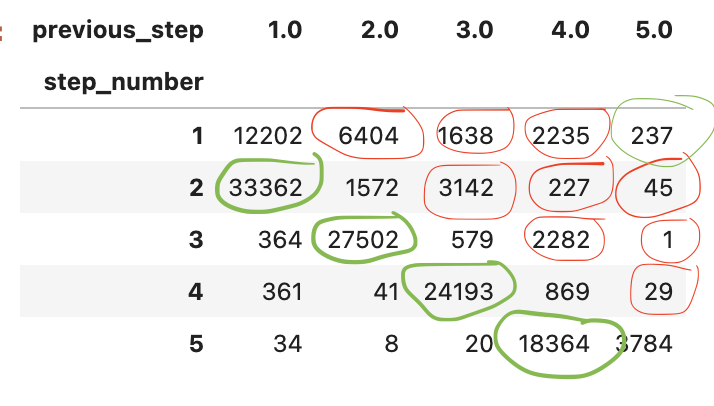

In [471]:
Image("../figures/error_current_previous.png")

In [296]:
def calculate_error_rate(df):
    step_mapping = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}
    
    error = df
    error['step_number'] = error['process_step'].map(step_mapping)
    error = error.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'])
    
    # Shift the step_number to compare with the previous step for the same user
    error['previous_step'] = error.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(1)
    
    # Create the error column: 1 if moving to an earlier step, 0 otherwise
    error['error'] = (error['step_number'] < error['previous_step']).astype(int)
    
    # Replacing error = 0 for confirm > start
    error['error'] = np.where((error["step_number"]==1) & (error["previous_step"]==5), 0, error['error'])
    
    # Total Number of Errors by Process Step
    error_bystep = error.groupby('previous_step')[['error']].sum().reset_index()
    
    error = error.groupby('client_id')[['error']].sum().reset_index()
    error["error"] = error['error'].apply(lambda x: 1 if x >= 1 else 0)
    error[["total_client"]] = 1
    error = error[['error','total_client']].sum()
    error_rate = round(error["error"] / error["total_client"] * 100, 2)

    return error_rate

#### Error Rate (Test Group)

In [293]:
error_rate_test = calculate_error_rate(test)
error_rate_test

32.87

#### Error Rate (Control Group)

In [297]:
error_rate_control = calculate_error_rate(control)
error_rate_control

24.72

In [298]:
print(f"Error Rate (Test Group):{error_rate_test}%")
print(f"Error Rate (Control Group):{error_rate_control}%")

Error Rate (Test Group):32.87%
Error Rate (Control Group):24.72%


In [299]:
error_test_bystep

,previous_step,error
0,1.0,0
1,2.0,6404
2,3.0,4780
3,4.0,4744
4,5.0,75


In [300]:
error_control_bystep

,previous_step,error
0,1.0,0
1,2.0,2491
2,3.0,2163
3,4.0,4247
4,5.0,228


### 4. Other metrics

- Number of visit (by visit_id) per day
- Number of active user (by client_id) per day

In [475]:
test_control = pd.concat([test, control], ignore_index=True)

In [477]:
test_control.to_csv('../data/cleaned/test_control.csv', index=False)

Next step: Visualization at Tableau

#### 5. Export Datasets for Visualization at Tableau

In [15]:
# Completion Rate
Completion_Rate_test.to_csv('../data/cleaned/completion_rate_test.csv', index=False)
Completion_Rate_control.to_csv('../data/cleaned/completion_rate_control.csv', index=False)

## Hypothesis Testing

### 1. Completion Rate

### Completion Rate Overall

In [148]:
# Set Hypothesis
#H0: CR_test <= CR_control
#H1: CR_test > CR_control

# Choose significance level
alpha = 0.05

#Collect data
CR_test = Completion_Rate_test["num_users"][4]
total_test = Completion_Rate_test["num_users"][0]
CR_control = Completion_Rate_control["num_users"][4]
total_control = Completion_Rate_control["num_users"][0]

successes = np.array([CR_test, CR_control])
nobs = np.array([total_test, total_control])

# Compute test statistic: Perform a one-sided z-test where H0: CR_test <= CR_control
z_stat, p_value = proportions_ztest(successes, nobs, alternative='larger')

# Output the results
print(f"Z-statistic: {z_stat}, P-value: {p_value}")

# Decision making
if p_value > alpha:
    print("We are not able to reject the null hypothesis H0: CR_test <= CR_control")
else:
    print("We reject the null hypothesis in favor of the alt. hypothesis, meaning the Test group's CR was significantly higher than the Control group's")

Z-statistic: 8.62493582934689, P-value: 3.206430139464171e-18
We reject the null hypothesis in favor of the alt. hypothesis, meaning the Test group's CR was significantly higher than the Control group's


In [79]:
# Set Hypothesis
#H0: CR_test <= CR_control
#H1: CR_test > CR_control

n1 = Completion_Rate_test["num_users"][0]    # Test group: n1 observations (26679)
x1 = Completion_Rate_test["num_users"][4]    # Test group: x1 completions (18445)
n2 = Completion_Rate_control["num_users"][0] # Control group: n2 observations (23397)
x2 = Completion_Rate_control["num_users"][4] # Control group: x2 completions (15329)

# Perform the test (nobs stands for num of obs)
count = [x1, x2]
nobs = [n1, n2]

z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
one_tailed_p_value = p_value / 2 if z_stat > 0 else 1 - (p_value / 2)
print(f"One-tailed (Test > Control) Z-statistic: {z_stat}, P-value: {one_tailed_p_value}")

if one_tailed_p_value > alpha:
    print("We are not able to reject the null hypothesis that states the test group CR is less than or equal to the control group CR")
else:
    print("We reject the null hypothesis, meaning the test group CR is significantly greater than the control group CR")

One-tailed (Test > Control) Z-statistic: 8.62493582934689, P-value: 3.206430139464171e-18
We reject the null hypothesis, meaning the test group CR is significantly greater than the control group CR


### Completion Rate per Step

In [87]:
# Set Hypothesis
#H0: step_CR_test <= step_CR_control
#H1: step_CR_test > step_CR_control

# initialize confidence interval for 95%
alpha = 0.05

prev_t = Completion_Rate_test["num_users"][0]                  # Test group: n1 observations (26679)
test_stepvalues = Completion_Rate_test["num_users"][1:5]       # Test group: x1 completions [24201, 22243, 20834, 18445]

prev_c = Completion_Rate_control["num_users"][0]               # Control group: n2 observations (23397)
control_stepvalues = Completion_Rate_control["num_users"][1:5] # Control group: x2 completions [20082, 18633, 17356, 15329]

CR_p_value_step = [None]

for t, c in zip(test_stepvalues, control_stepvalues):   
    # Perform the proportion test (nobs stands for num of obs)
    count = [t, c]
    nobs = [prev_t, prev_c]
    
    z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
    one_tailed_p_value = p_value / 2 if z_stat > 0 else 1 - (p_value / 2)
    print(f"One-tailed (Test > Control) Z-statistic: {z_stat}, P-value: {one_tailed_p_value}")
    CR_p_value_step.append(one_tailed_p_value)

    # print results
    if one_tailed_p_value > alpha:
        print(f"We are not able to reject the null hypothesis that states the test CR step-value, {t}, is less than or equal to the control group CR step-value, {c}, which are at the same step\n")
    else:
        print(f"We reject the null hypothesis, meaning the test group CR step-value, {t}, is significantly greater than the control group CR step-value, {c}, which are at the same step\n")
        
    # updating the previous step
    prev_t = t                                  
    prev_c = c

One-tailed (Test > Control) Z-statistic: 17.035466844909493, P-value: 2.2407555776886253e-65
We reject the null hypothesis, meaning the test group CR step-value, 24201, is significantly greater than the control group CR step-value, 20082, which are at the same step

One-tailed (Test > Control) Z-statistic: -3.44036760073488, P-value: 0.9997095377077352
We are not able to reject the null hypothesis that states the test CR step-value, 22243, is less than or equal to the control group CR step-value, 18633, which are at the same step

One-tailed (Test > Control) Z-statistic: 2.1085813831892164, P-value: 0.017490365610442267
We reject the null hypothesis, meaning the test group CR step-value, 20834, is significantly greater than the control group CR step-value, 17356, which are at the same step

One-tailed (Test > Control) Z-statistic: 0.6454647235298567, P-value: 0.2593130358577156
We are not able to reject the null hypothesis that states the test CR step-value, 18445, is less than or equa

### Completion Rate Percentage Point Difference

In [33]:
CR_test_pp = Completion_Rate_test.copy()
CR_test_pp['percentage_point_diff'] = Completion_Rate_test['CR_test'].diff().abs()
CR_test_pp

,process_step,num_users,CR_test,percentage_point_diff
0,start,26679,100.00,NaN
1,step_1,24201,90.71,9.29
2,step_2,22243,83.37,7.34
3,step_3,20834,78.09,5.28
4,confirm,18445,69.14,8.95


In [25]:
CR_control_pp = Completion_Rate_control.copy()
CR_control_pp['percentage_point_diff'] = Completion_Rate_control['CR_control'].diff().abs()
CR_control_pp

,process_step,num_users,CR_control,percentage_point_diff
0,start,23397,100.00,NaN
1,step_1,20082,85.83,14.17
2,step_2,18633,79.64,6.19
3,step_3,17356,74.18,5.46
4,confirm,15329,65.52,8.66


### Completion Rate: Big Comparison Table

In [52]:
CR_tbl_test = CR_test_pp.copy()
CR_tbl_test.rename(columns={'process_step': 'process_step', 'num_users': 'num_users_test', 'CR_test': 'CR_test', 
                       'percentage_point_diff':'pp_diff_test'}, inplace=True)

In [54]:
CR_tbl_control = CR_control_pp.copy()
CR_tbl_control.rename(columns={'process_step':'process_step_rm', 'num_users': 'num_users_control', 
                       'CR_control': 'CR_control', 'percentage_point_diff':'pp_diff_control'}, inplace=True)

In [55]:
CR_tbl = pd.concat([CR_tbl_test, CR_tbl_control],axis=1)
CR_tbl.columns

Index(['process_step', 'num_users_test', 'CR_test', 'pp_diff_test',
       'process_step_rm', 'num_users_control', 'CR_control',
       'pp_diff_control'],
      dtype='object')

In [88]:
# CR_tbl = CR_tbl.drop('process_step_rm', axis=1)
CR_tbl['p-value'] = CR_p_value_step
CR_tbl['p-value'] = CR_tbl['p-value'].round(2)

In [91]:
def classify_p_value(p):
    if np.isnan(p):
        return 'NA'
    elif p < 0.05:
        return 'Yes'
    else:
        return 'No'

In [93]:
CR_tbl['significant'] = CR_tbl['p-value'].apply(classify_p_value)

In [94]:
CR_tbl

,process_step,num_users_test,CR_test,pp_diff_test,num_users_control,CR_control,pp_diff_control,p-value,significant
0,start,26679,100.00,NaN,23397,100.00,NaN,NaN,NA
1,step_1,24201,90.71,9.29,20082,85.83,14.17,0.00,Yes
2,step_2,22243,83.37,7.34,18633,79.64,6.19,1.00,No
3,step_3,20834,78.09,5.28,17356,74.18,5.46,0.02,Yes
4,confirm,18445,69.14,8.95,15329,65.52,8.66,0.26,No


### Completion Rate with a Cost-Effectiveness Threshold

In [184]:
# we want to evaluate whether the observed increase in the completion rate meets or exceeds the 5% threshold set by Vanguard

# Set Hypothesis
# H0: (CR_test - CR_control) <= 5 % points
# H1: (CR_test - CR_control) > 5 % points


# initialize confidence interval for 95%
alpha = 0.05

nt = Completion_Rate_test["num_users"][0]    # Test group: n1 observations (26679)
xt = Completion_Rate_test["num_users"][4]    # Test group: x1 completions (18445)
nc = Completion_Rate_control["num_users"][0] # Control group: n2 observations (23397)
xc = Completion_Rate_control["num_users"][4] # Control group: x2 completions (15329)

successes = np.array([xt, xc])
nobs = np.array([nt, nc])

# Compute test statistic: Perform a one-sided z-test where H0: CR_test <= CR_control
z_stat, p_value = proportions_ztest(successes, nobs, alternative='larger')

# Output the results
print(f"Z-statistic: {z_stat}, P-value: {p_value}")

if p_value_CET < alpha:
    print("Reject the null hypothesis: The new design's impact is statistically significant.")
else:
    print("Fail to reject the null hypothesis: The new design's impact is not statistically significant.")

# AI suggestion
# improvement_threshold = 0.05

# # Combine data to calculate pooled standard error
# prop_combined = (xc * nc + xt * nt) / (nc + nt)
# std_e = (prop_combined * (1 - prop_combined) * (1/nc + 1/nt))**0.5

# # Calculate Z-score for one-sample proportion test (one-tailed)
# z_score_CET = (xt - (xc + improvement_threshold)) / std_e

# # Calculate p-value
# p_value_CET = 1 - stats.norm.cdf(z_score_CET)

# # Display the results
# print(f"Z-Score: {z_score_CET:.4f}")
# print(f"P-Value: {p_value_CET:.4f}")

Z-Score: nan
P-Value: nan
Fail to reject the null hypothesis: The new design's impact is not statistically significant.


/var/folders/ns/cnr3tjln5ns_6pvq3ylpgl9m0000gn/T/ipykernel_24602/2642405964.py:20: RuntimeWarning: invalid value encountered in scalar power
  std_e = (prop_combined * (1 - prop_combined) * (1/nc + 1/nt))**0.5


### 2. Average Duration

  Notes: There is no start step present because:
- the time it takes from start to step 1 fall under step 1's record... & then   
- the time b/w step 1 & step 2 goes to step 2
- the time b/w step 2 & step 3 goes to step 3
- the time b/w step 3 & confirmation goes to confirmation    

In other words, there are 5 steps but only 4 differences

### General Duration Info.

In [187]:
total_avg_dur_test = test_time['duration'].sum()

Timedelta('0 days 00:03:01.346248999')

In [188]:
total_avg_dur_control = control_time['duration'].sum()

Timedelta('0 days 00:03:27.770032476')

In [202]:
def convert_seconds_to_minutes(seconds):
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes:02}:{remaining_seconds:05.2f}"

In [203]:
test_time_ht = test_time.copy()
test_time_ht['duration_seconds'] = pd.to_timedelta(test_time_ht['duration']).dt.total_seconds().round(2)
test_time_ht['duration_minutes'] = test_time_ht['duration_seconds'].apply(convert_seconds_to_minutes)
test_time_ht

,process_step,duration,count,duration_seconds,duration_minutes
0,step_1,0 days 00:00:11.548810816,28549,11.55,00:11.55
1,step_2,0 days 00:00:27.246498927,25635,27.25,00:27.25
2,step_3,0 days 00:01:09.999469120,22604,70.00,01:10.00
3,confirm,0 days 00:01:12.551470136,16291,72.55,01:12.55


In [212]:
control_time_ht = control_time.copy()
control_time_ht['duration_seconds'] = pd.to_timedelta(control_time_ht['duration']).dt.total_seconds().round(2)
control_time_ht['duration_minutes'] = control_time_ht['duration_seconds'].apply(convert_seconds_to_minutes)
control_time_ht

,process_step,duration,count,duration_seconds,duration_minutes
0,step_1,0 days 00:00:21.430498981,23568,21.43,00:21.43
1,step_2,0 days 00:00:24.045226856,20762,24.05,00:24.05
2,step_3,0 days 00:01:11.645597405,20045,71.65,01:11.65
3,confirm,0 days 00:01:30.648709234,13829,90.65,01:30.65


### Avg Duration Overall
This means the total time spent from start to confirmation  

**OJO: When using a two-sample t-test, the sample durations must be normally distributed for the CLT to apply**

In [209]:
"""
FOUND LOGIC ERROR HERE:
The test- & control_time_ht tables above were initially used as the data I fed the stats test with.
Here's 2 problems: 

1 -> the test was only taking the 'duration_seconds' into account, 
meaning it didn't have the count # which is a problem because the test thinks there's only one count 
of 21.34, for example. The test doesn't know that is an average (distribution is missing). This is why 
the test result said we cannot reject the null hypo, because it thought it only had one observation, 
despite it being an aggregated number.
I thought this wouldn't be an issue, but then when I ran the duration per step test, it rejected the null
hypothesis at each step, so I thought something isn't right here.

2 -> the data included visits that didn't complete the whole process. That isn't a problem for getting an avg.
per step, but it does matter for testing the avg total duration as the test will think that a visit completed
the process in say 10 seconds (only one step), meaning the distribution will be skewed towards shorter 
durations.

This means we need to drop all visits that didn't complete the process
"""

# Set Hypothesis
#H0: total_avg_duration_test = total_avg_duration_control
#H1: total_avg_duration_test <> total_avg_duration_control

# initialize confidence interval for 95%
alpha = 0.05

test_tt = test_time_ht['duration_seconds']
control_tt = control_time_ht['duration_seconds']

t_stat, p_value_dur = st.ttest_ind(test_tt,control_tt, equal_var=False)

if p_value_dur > alpha:
    print("We are not able to reject the null hypothesis that states that there is not difference between the two group's total duration")
else:
    print("We reject the null hypothesis, meaning the test group's total duration is significantly different than the control group's total duration")

We are not able to reject the null hypothesis that states that there is not difference between the two group's total duration


In [336]:
# The two series below show how long each visit took (given they completed the whole process):
test_total_durations

visit_id
100019538_17884295066_43909     187.0
100022086_87870757897_149620    180.0
100173292_91322748906_143563     95.0
100217156_67053490690_383412    267.5
100321067_78502191718_46799     134.0
                                ...  
999832879_53726542508_358970    284.0
999954858_74676709104_879685    127.0
999958344_67534252886_39917     147.0
999971096_28827267783_236076    102.0
999984454_18731538378_781808    154.0
Name: duration_seconds, Length: 12939, dtype: float64

In [328]:
test_time_step_counts = test_time_step.groupby('visit_id').size().sort_values()
test_total_durations = test_time_step[test_time_step['visit_id'].isin(
    test_time_step_counts[test_time_step_counts==4].index
)].groupby('visit_id')['duration_seconds'].sum()

In [329]:
control_time_step_counts = control_time_step.groupby('visit_id').size().sort_values()
control_total_durations = control_time_step[control_time_step['visit_id'].isin(
    control_time_step_counts[control_time_step_counts==4].index
)].groupby('visit_id')['duration_seconds'].sum()

In [337]:
"""
Here we retested the overall duration average based on the series above 
"""

# Set Hypothesis
#H0: total_avg_duration_test = total_avg_duration_control
#H1: total_avg_duration_test <> total_avg_duration_control

# initialize confidence interval for 95%
alpha = 0.05

test_tt = test_time_ht['duration_seconds']
control_tt = control_time_ht['duration_seconds']

t_stat, p_value_dur = st.ttest_ind(control_time_step_counts.to_list(), control_total_durations.to_list(), equal_var=False)

if p_value_dur > alpha:
    print("We are not able to reject the null hypothesis that states that there is not difference between the two group's total duration")
else:
    print("We reject the null hypothesis, meaning the test group's total duration is significantly different than the control group's total duration")

print(t_stat, p_value_dur)

We reject the null hypothesis, meaning the test group's total duration is significantly different than the control group's total duration
-231.225927954721 0.0


### Avg Duration per Step

In [314]:
test_time_step = calculate_durations_per_step(test)
test_time_step.head()

,visit_id,process_step,duration,duration_seconds
0,100019538_17884295066_43909,step_1,0 days 00:00:10.500000,10.5
1,100019538_17884295066_43909,step_2,0 days 00:00:06.500000,6.5
2,100019538_17884295066_43909,step_3,0 days 00:01:53,113.0
3,100019538_17884295066_43909,confirm,0 days 00:00:57,57.0
4,100022086_87870757897_149620,step_1,0 days 00:00:22,22.0


In [309]:
control_time_step = calculate_durations_per_step(control)
control_time_step.head()

,visit_id,process_step,duration,duration_seconds
0,100037962_47432393712_705583,step_1,0 days 00:00:39,39.0
1,100057941_88477660212_944512,step_1,0 days 00:00:30,30.0
2,100057941_88477660212_944512,step_2,0 days 00:00:53.500000,53.5
3,100057941_88477660212_944512,step_3,0 days 00:00:45,45.0
4,10006594_66157970412_679648,step_1,0 days 00:00:10,10.0


In [259]:
test_time_step.shape

(84256, 4)

In [312]:
# Setting Hypothesis for each step
# H0: avg_duration_test = avg_duration_control
# H1: avg_duration_test <> avg_duration_control

# Initialize confidence interval for 95%
alpha = 0.05

# List to store the results
results = []

for step in test_time['process_step']:
    test_step = test_time_step[test_time_step['process_step'] == step]['duration_seconds'].to_list()
    control_step = control_time_step[control_time_step['process_step'] == step]['duration_seconds'].to_list()
    
    # Without specifying equal_var directly, let it default to True, typically desired for similar sample sizes
    t_stat_tstep, p_value_tstep = st.ttest_ind(test_step, control_step, equal_var=False)

    if p_value > alpha:
        result = f"For {step}, we are not able to reject the null hypothesis that there is no difference in duration.\n"
    else:
        result = f"For {step}, we reject the null hypothesis, meaning the test group's duration is significantly different than the control group's duration.\n"

    results.append(result)

    # Print the results
    print(result)
    print(t_stat_tstep, p_value_tstep)

For step_1, we reject the null hypothesis, meaning the test group's duration is significantly different than the control group's duration.

-79.46529543472025 0.0
For step_2, we reject the null hypothesis, meaning the test group's duration is significantly different than the control group's duration.

15.186642848651793 6.128970026896264e-52
For step_3, we reject the null hypothesis, meaning the test group's duration is significantly different than the control group's duration.

-7.483090664568523 7.43195166917239e-14
For confirm, we reject the null hypothesis, meaning the test group's duration is significantly different than the control group's duration.

-25.09356001291196 1.9253939657163832e-137


In [ ]:
"""
The code block below was used to make the test- & control_time_step tables
"""

In [307]:
def calculate_durations_per_step(df):
    step_mapping = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}
    
    time_step = df[['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time','Variation']]
    time_step["step_number"] = time_step['process_step'].map(step_mapping)
    
    # Create next_step variable which contains next step number for the same visit_id
    time_step['next_step'] = time_step.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(-1)
    
    # Keep last timestamp if the next step is the same with current step for start and confirm
    time_step = time_step.drop(time_step[(time_step['step_number']==1) & (time_step['next_step']==1)].index)
    time_step = time_step.drop(time_step[(time_step['step_number']==5) & (time_step['next_step']==5)].index)
    time_step.drop('next_step',axis=1,inplace=True)
    
    # Create previous_step variable which contains previous step number for the same visit_id
    time_step['previous_step'] = time_step.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(1)
    
    # Calculate difference between current step and previous step
    time_step["diff"] = time_step['step_number'] - time_step['previous_step']
    
    # Change formate to datetime
    time_step["date_time"] = pd.to_datetime(time_step["date_time"])
    
    # Calculate duration (current_step date_time - previous_step date_time) by visit_id
    time_step['date_time_previous'] = time_step.groupby(['client_id', 'visitor_id','visit_id'])['date_time'].shift(1)
    time_step = time_step[time_step["diff"]==1]
    time_step["duration"] = time_step["date_time"] - time_step['date_time_previous']
    
    # Create new df for each step
    #test_time_start = test_time[test_time["process_step"]=="start"]
    time_step_1 = time_step[time_step["process_step"]=="step_1"]
    time_step_2 = time_step[time_step["process_step"]=="step_2"]
    time_step_3 = time_step[time_step["process_step"]=="step_3"]
    time_confirm = time_step[time_step["process_step"]=="confirm"]
    
    time_step_1 = drop_duration_outliers(time_step_1)
    time_step_2 = drop_duration_outliers(time_step_2)
    time_step_3 = drop_duration_outliers(time_step_3)
    time_confirm = drop_duration_outliers(time_confirm)
    
    # Combine the data again
    time_step = pd.concat([time_step_1, time_step_2, time_step_3, time_confirm],
                               ignore_index=True)
    
    time_step = time_step.groupby(['visit_id','step_number'])[['duration']].mean().reset_index()
    
    step_number_mapping = {2:'step_1', 3:'step_2', 4 :'step_3', 5:'confirm'}
    time_step["process_step"] = time_step['step_number'].map(step_number_mapping)
    
    time_step = time_step[["visit_id","process_step","duration"]]
    
    time_step['duration_seconds'] = pd.to_timedelta(time_step['duration']).dt.total_seconds().round(2)
    return time_step

### 3. Error Rate

### Error Rate Overall

In [98]:
print(f"Error Rate (Test Group):{error_rate_test}%")
print(f"Error Rate (Control Group):{error_rate_control}%")

Error Rate (Test Group):32.87%
Error Rate (Control Group):24.72%


In [146]:
error_test

error            8864
total_client    26968
dtype: int64

In [149]:
error_control

error            5816
total_client    23532
dtype: int64

In [170]:
# Set Hypothesis
#H0: ER_test = ER_control
#H1: ER_test <> ER_control

# initialize confidence interval for 95%
alpha = 0.05

er_n1 = error_test['total_client']    # Test group: n1 observations (total)
er_x1 = error_test['error']           # Test group: x1 completions ('success')
er_n2 = error_control['total_client'] # Control group: n2 observations (total)
er_x2 = error_control['error']        # Control group: x2 completions ('success')

# Perform the test (nobs stands for num of obs)
count = [er_x1, er_x2]
nobs = [er_n1, er_n2]

z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
print(f"Two-tailed Z-statistic: {z_stat}, P-value: {p_value}")

if p_value > alpha:
    print("We are not able to reject the null hypothesis that states that there is not difference between the two group's ER")
else:
    print("We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER")


Two-tailed Z-statistic: 20.128308406630296, P-value: 4.1698788269810905e-90
We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER


### Error Rate by Step

In [144]:
step_mapping = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}

s_error_control = control
s_error_control['step_number'] = s_error_control['process_step'].map(step_mapping)
s_error_control = s_error_control.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'])

# Shift the step_number to compare with the previous step for the same user
s_error_control['previous_step'] = s_error_control.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(1)

# Create the error column: 1 if moving to an earlier step, 0 otherwise
s_error_control['error'] = (s_error_control['step_number'] < s_error_control['previous_step']).astype(int)

# Replacing error = 0 for confirm > start
s_error_control['error'] = np.where((s_error_control["step_number"]==1) & (s_error_control["previous_step"]==5), 0, s_error_control['error'])

# Total Number of Errors by Process Step
s_error_control_bystep = s_error_control.groupby('previous_step')[['error']].sum().reset_index()

# getting the number of visits that went on to the next step correctly, aka 'not error'
s_noterror_control = s_error_control.assign(not_error=1-s_error_control['error'])
s_noterror_control = s_noterror_control[s_noterror_control['previous_step'] + 1 == s_noterror_control['step_number']]\
    .groupby('previous_step')['not_error'].sum().reset_index()

error_stats_bystep_control = error_control_bystep.merge(s_noterror_control, on='previous_step', how='outer')
error_stats_bystep_control['total_observations'] = error_stats_bystep_control[['error', 'not_error']].sum(axis=1)
error_stats_bystep_control['error_rate'] = error_stats_bystep_control['error'] / error_stats_bystep_control['total_observations']

In [142]:
step_mapping = {'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4, 'confirm': 5}

s_error_test = test
s_error_test['step_number'] = s_error_test['process_step'].map(step_mapping)
s_error_test = s_error_test.sort_values(by=['client_id', 'visitor_id', 'visit_id', 'date_time'])

# Shift the step_number to compare with the previous step for the same user
s_error_test['previous_step'] = s_error_test.groupby(['client_id', 'visitor_id','visit_id'])['step_number'].shift(1)

# Create the error column: 1 if moving to an earlier step, 0 otherwise
s_error_test['error'] = (s_error_test['step_number'] < s_error_test['previous_step']).astype(int)

# Replacing error = 0 for confirm > start
s_error_test['error'] = np.where((s_error_test["step_number"]==1) & (s_error_test["previous_step"]==5), 0, s_error_test['error'])

# Total Number of Errors by Process Step
s_error_test_bystep = s_error_test.groupby('previous_step')[['error']].sum().reset_index()

# getting the number of visits that went on to the next step correctly, aka 'not error'
s_noterror_test = s_error_test.assign(not_error=1-s_error_test['error'])
s_noterror_test = s_noterror_test[s_noterror_test['previous_step'] + 1 == s_noterror_test['step_number']]\
    .groupby('previous_step')['not_error'].sum().reset_index()

error_stats_bystep_test = error_test_bystep.merge(s_noterror_test, on='previous_step', how='outer')
error_stats_bystep_test['total_observations'] = error_stats_bystep_test[['error', 'not_error']].sum(axis=1)
error_stats_bystep_test['error_rate'] = error_stats_bystep_test['error'] / error_stats_bystep_test['total_observations']

In [143]:
error_stats_bystep_test

,previous_step,error,not_error,total_observations,error_rate
0,1.0,0,33362.0,33362.0,0.000000
1,2.0,6404,27502.0,33906.0,0.188875
2,3.0,4780,24193.0,28973.0,0.164981
3,4.0,4744,18364.0,23108.0,0.205297
4,5.0,75,NaN,75.0,1.000000


In [145]:
error_stats_bystep_control

,previous_step,error,not_error,total_observations,error_rate
0,1.0,0,25769.0,25769.0,0.000000
1,2.0,2491,22329.0,24820.0,0.100363
2,3.0,2163,21268.0,23431.0,0.092314
3,4.0,4247,15284.0,19531.0,0.217449
4,5.0,228,NaN,228.0,1.000000


In [175]:
# Set Hypothesis
#H0: ER_test_steps = ER_control_steps
#H1: ER_test_steps <> ER_control_steps

# initialize confidence interval for 95%
alpha = 0.05

ers_n1 = error_stats_bystep_test['total_observations']   # Test group: n1 observations (total)
ers_x1 = error_stats_bystep_test['error']          # Test group: x1 completions ('success')

ers_n2 = error_stats_bystep_control['total_observations'] # Control group: n2 observations (total)
ers_x2 = error_stats_bystep_control['error']        # Control group: x2 completions ('success')

# Initialize lists to hold z-statistics and p-values for each step
ER_p_value_step = []
ER_z_stat_step = []

# Loop through the dataframes row-by-row
for i in range(len(error_stats_bystep_test)):
    count = [ers_x1[i], ers_x2[i]]
    nobs = [ers_n1[i], ers_n2[i]]

    z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
    ER_p_value_step.append(p_value)
    ER_z_stat_step.append(z_stat)
    
    print(f"Step {i+1} -> Two-tailed Z-statistic: {z_stat}, P-value: {p_value}")
    
    if p_value > alpha:
        print("We are not able to reject the null hypothesis that states that there is not difference between the two group's ER\n")
    else:
        print("We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER\n")

Step 1 -> Two-tailed Z-statistic: nan, P-value: nan
We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER

Step 2 -> Two-tailed Z-statistic: 29.5553617302073, P-value: 5.603751537525367e-192
We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER

Step 3 -> Two-tailed Z-statistic: 24.39619145721428, P-value: 1.8770038485653898e-131
We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER

Step 4 -> Two-tailed Z-statistic: -3.0649427656277464, P-value: 0.002177116557654631
We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER

Step 5 -> Two-tailed Z-statistic: nan, P-value: nan
We reject the null hypothesis, meaning the test group's ER is significantly different than the control group's ER



In [189]:
pd.DataFrame(
    {
        'p value': ER_p_value_step,
        'z stat': ER_z_stat_step
    }
)

,p value,z stat
0,NaN,NaN
1,5.603752e-192,29.555362
2,1.877004e-131,24.396191
3,2.177117e-03,-3.064943
4,NaN,NaN


### 4. Others

# GRAVEYARD CODE

This logic of the below code was flawed...the comparision should have been between the CR for the test & control group steps,   
NOT between the steps themselves (in the same group)

In [ ]:
# import statsmodels.api as sm
# # Set Hypothesis
# #H0: step_CR_test <= step_CR_control
# #H1: step_CR_test > step_CR_control

# # initialize confidence interval for 95%
# alpha = 0.05

# # initial & step values for test & control
# prev_t = Completion_Rate_test["num_users"][0]                  #(26679) -> Test group: n1 observations 
# prev_c = Completion_Rate_control["num_users"][0]               #(23397) -> Cntrl group: n2 observations
# test_stepvalues = Completion_Rate_test["num_users"][1:5]       #[24201, 22243, 20834, 18445]
# control_stepvalues = Completion_Rate_control["num_users"][1:5] #[20082, 18633, 17356, 15329]
# CR_p_value_diff = [None]

# # iterate over the test & control values
# for t, c in zip(test_stepvalues, control_stepvalues):
#     # calc. the diff. for each step compared to the previous step
#     tstep_diff = prev_t - t                                    # Test group: x1 completions
#     cstep_diff = prev_c - c                                    # Cntrl group: x2 completions

#     # prepare the data for the hypo test
#     count = [tstep_diff, cstep_diff]
#     nobs = [prev_t, prev_c]      

#     # perform the hypo test
#     z_stat, p_value = sm.stats.proportions_ztest(count, nobs)
#     one_tailed_p_value = p_value / 2 if z_stat > 0 else 1 - (p_value / 2)
#     CR_p_value_diff.append(one_tailed_p_value)

#     # print results
#     print(f"One-tailed (Test > Control) Z-statistic: {z_stat}, P-value: {one_tailed_p_value}")

#     if one_tailed_p_value > alpha:
#         print(f"We are not able to reject the null hypothesis that states the test group CR for the difference between {prev_t} & {t} is less than or equal to the control group CR difference at the same step\n")
#     else:
#         print(f"We reject the null hypothesis, meaning the test group CR between step values {prev_t} & {t} is significantly greater than the control group CR difference at the same step\n")
        
#     # update the previous values
#     prev_t = t
#     prev_c = c